## Setup

**Import**

In [208]:
import re
from math import asin, cos, radians, sin, sqrt

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.dates import DateFormatter
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform

In [209]:
CRS = "EPSG:4326"

STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

**Utility functions**

In [210]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [211]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

In [212]:
def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g

In [213]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [214]:
def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Graph signal processing using SGL

In [482]:
data_df, stations_df, description = load_molene_meteo_dataset()

## Data pre-processing

In [216]:
# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond]

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [217]:
data_df.head()

,numer_sta,date,date_insert,td,t,tx,tn,u,ux,un,...,vv,etat_sol,sss,n,insolh,ray_glo01,pres,pmer,station_name,temp
0,29168001,2014-01-01 00:00:00,2014-01-01 00:03:54,280.35,283.65,283.75,283.55,80.0,83.0,78.0,...,30000.0,1.0,NaN,1.0,NaN,NaN,99520.0,100490.0,PTE DU RAZ,10.5
1,29168001,2014-01-01 01:00:00,2014-01-01 01:03:59,279.45,282.95,283.85,282.95,79.0,82.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99410.0,100380.0,PTE DU RAZ,9.8
2,29168001,2014-01-01 02:00:00,2014-01-01 02:04:05,280.85,283.75,283.75,282.55,82.0,84.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99350.0,100320.0,PTE DU RAZ,10.6
3,29168001,2014-01-01 03:00:00,2014-01-01 03:03:09,280.95,283.75,283.85,283.65,83.0,84.0,80.0,...,30000.0,1.0,NaN,7.0,NaN,NaN,99230.0,100200.0,PTE DU RAZ,10.6
4,29168001,2014-01-01 04:00:00,2014-01-01 04:03:14,281.15,283.55,284.05,283.55,85.0,86.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,99110.0,100080.0,PTE DU RAZ,10.4


Pivot the table. We now have a multivariate time serie.

In [218]:
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df.head()

station_name,ARZAL,AURAY,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,DINARD,GUERANDE,ILE DE GROIX,ILE-DE-BREHAT,...,SAINT-CAST-LE-G,SARZEAU SA,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,11.3,7.1,9.7,NaN,6.8,10.4,9.0,7.0,...,6.1,9.8,7.4,8.5,8.3,7.5,9.0,9.0,9.3,9.7
2014-01-01 01:00:00,9.8,10.4,10.3,7.6,9.6,9.2,6.5,10.6,10.0,7.0,...,6.3,9.9,8.2,8.3,8.6,7.0,9.1,9.5,9.1,9.9
2014-01-01 02:00:00,9.7,10.0,11.2,7.7,9.1,9.4,6.5,10.2,9.5,7.8,...,6.4,9.2,8.5,8.5,8.6,7.5,9.5,9.4,9.4,9.6
2014-01-01 03:00:00,9.4,10.4,11.4,7.9,9.7,10.1,7.1,10.6,10.4,8.3,...,7.0,10.1,8.5,8.7,8.9,7.2,9.0,9.9,8.9,9.8
2014-01-01 04:00:00,9.8,10.8,11.4,8.8,9.8,10.2,7.6,10.6,10.8,8.9,...,7.7,10.5,9.1,9.1,9.4,7.6,9.5,10.0,9.6,10.2


Plot the position of the grounds stations on a map.

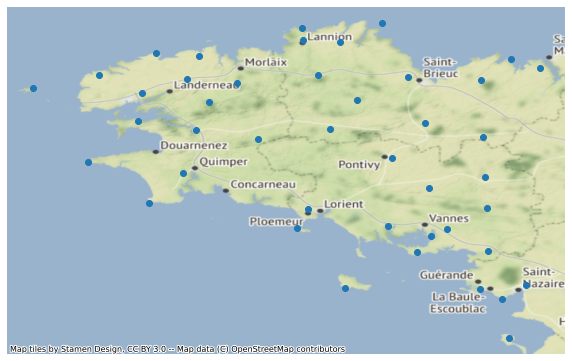

In [305]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

## Data exploration

We can start by checking for some malfunctions in the stations. To that end, we simply count the number of NaNs.

In [220]:
temperature_df.isna().sum(axis=0).sort_values(ascending=False).head()

station_name
ST NAZAIRE-MONTOIR    70
LANNAERO              37
PLOUDALMEZEAU          2
ARZAL                  1
LANDIVISIAU            1
dtype: int64

After this, we can look at the (geodesic) distance between stations.

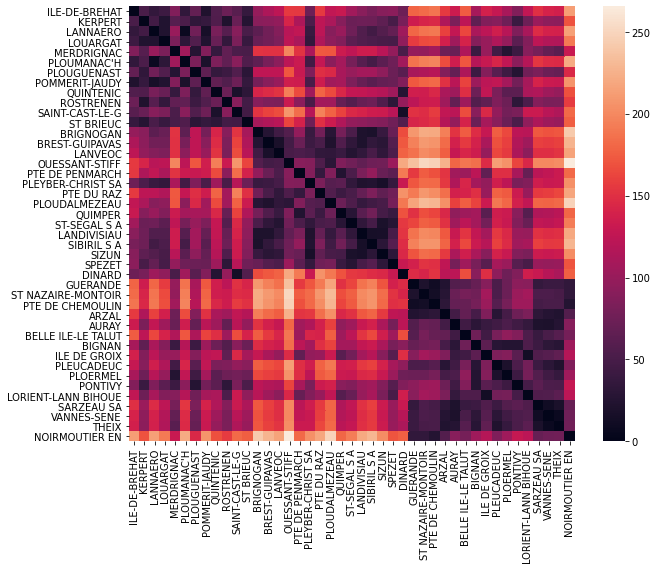

In [221]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

## Graph construction


### Distance-based weigthless graph

In [115]:
threshold = 40  # km
adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
G = graphs.Graph(adjacency_matrix)
print(
    f"The graph is {'not ' if not G.is_connected() else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

The graph is connected, with 43 nodes, 100 edges


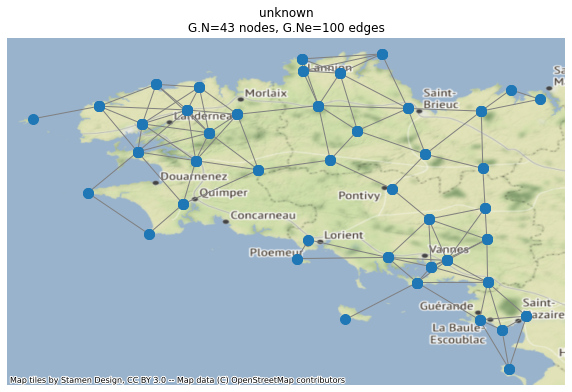

In [116]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

### Correlation graph

The correlation between the signals can also define a graph.

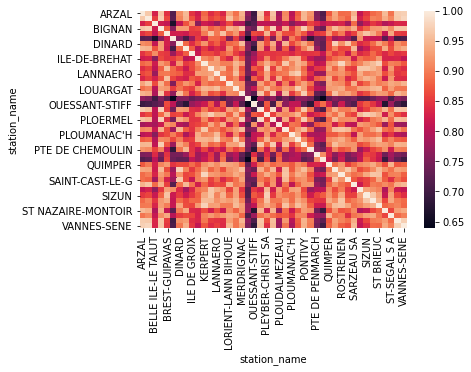

In [168]:
_ = sns.heatmap(temperature_df.corr())

In [436]:
correlation_matrix = temperature_df.corr().to_numpy()

correlation_threshold = 0.95
adjacency_matrix_corr = np.where(
    correlation_matrix > correlation_threshold, correlation_matrix, 0.0
)
np.fill_diagonal(a=adjacency_matrix_corr, val=0.0)
G_corr = graphs.Graph(adjacency_matrix_corr)
print(
    f"The graph is {'not ' if not G_corr.is_connected(recompute=True) else ''}connected, with {G_corr.N} nodes, {G_corr.Ne} edges"
)

The graph is not connected, with 43 nodes, 78 edges


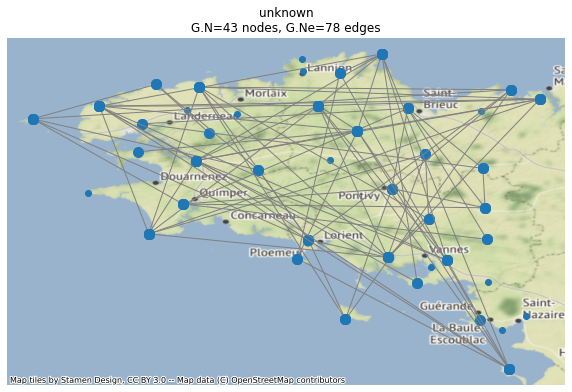

In [437]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_corr.set_coordinates(stations_np)
G_corr.plot(ax=ax)

The number of connected components is 12


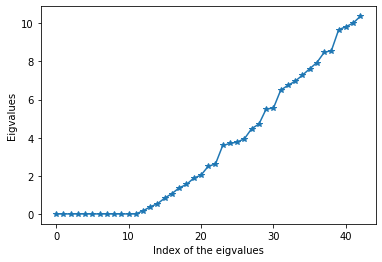

In [438]:
eig, eigv = np.linalg.eig(G_corr.L.todense())
plt.plot(sorted(eig), marker = '*')
plt.xlabel('Index of the eigvalues')
plt.ylabel('Eigvalues')
print("The number of connected components is %s" % np.bincount(np.where(np.abs(eig) < 1e-6)[0]).sum())


In [473]:
# choose a specific hour
choosen_hour = pd.to_datetime("2014-01-01 01:00:00")
G_corr.compute_laplacian('normalized')
laplacian_matrix = G_corr.L.todense()
signal = temperature_df_no_nan.loc[choosen_hour].to_numpy()
smoothness = float(signal.T.dot(laplacian_matrix).dot(signal))
print(f"Smoothness is {smoothness:.2f} ({choosen_hour})")

Smoothness is 1214.58 (2014-01-01 01:00:00)


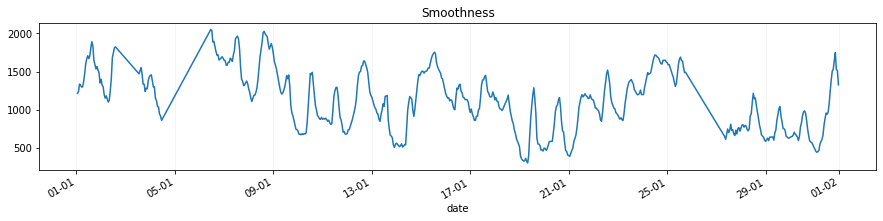

In [474]:
signals = temperature_df_no_nan.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

## Correlation-based SGL Graph

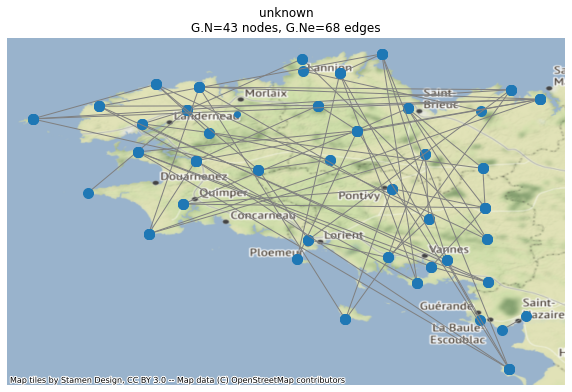

In [466]:
import SGL
import networkx as nx
from SGL.SGL import LearnGraphTopology

corr_squared = temperature_df.corr().values
sgl = LearnGraphTopology(corr_squared, n_iter=200, beta=0.022, alpha = 1e-2)
graph = sgl.learn_graph(k=1)
A = graph['adjacency']
G_sgl = graphs.Graph(A)


ax = stations_gdf.geometry.plot(figsize=(10, 10))
G_sgl.set_coordinates(stations_np)
G_sgl.plot(ax=ax)
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

/Users/samuel/Desktop/venv_dash/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The number of connected components is 4


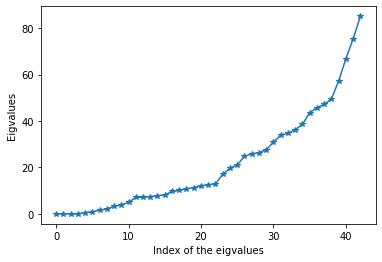

In [467]:
eig, eigv = np.linalg.eig(G_sgl.L.todense())
plt.plot(sorted(eig), marker = '*')
plt.xlabel('Index of the eigvalues')
plt.ylabel('Eigvalues')
print("The number of connected components is %s" % np.bincount(np.where(np.abs(eig) < 1e-6)[0]).sum())


<div class="alert alert-success" role="alert">
    <p>We can plot the evolution of the SGL objective function, we can see that we are indeed minimizing the objective, and it seems like we are reaching a plateau</p>
</div>

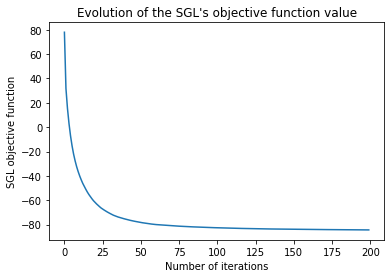

In [468]:
_ = plt.plot(graph['objective_seq'])
_ = plt.xlabel('Number of iterations')
_ = plt.ylabel('SGL objective function')
_ = plt.title("Evolution of the SGL's objective function value")

<div class="alert alert-success" role="alert">
    <p>We can also plot the evolution of the smoothness of the graph for the timeseries signals.</p>
</div>

In [478]:
# drop the NaNs
temperature_df_no_nan = temperature_df.dropna(axis=0, how="any")
# choose a specific hour
choosen_hour = pd.to_datetime("2014-01-01 01:00:00")
G_sgl.compute_laplacian('normalized')
laplacian_matrix = G_sgl.L.todense()
signal = temperature_df_no_nan.loc[choosen_hour].to_numpy()
smoothness = float(signal.T.dot(laplacian_matrix).dot(signal))
print(f"Smoothness is {smoothness:.2f} ({choosen_hour})")

Smoothness is 242.58 (2014-01-01 01:00:00)


/Users/samuel/Desktop/venv_dash/lib/python3.8/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


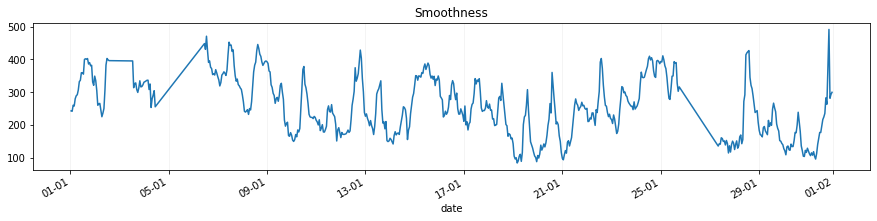

In [479]:
signals = temperature_df_no_nan.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

<div class="alert alert-success" role="alert">
    <p>This displays interesting patterns. We can show the state of the network, when the signal is the smoothest.</p>
</div>

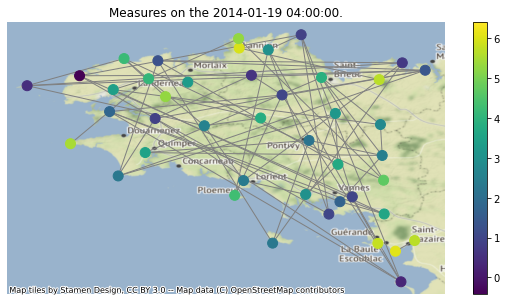

In [480]:
argmin_index = smoothness_df.argmin()
signal = temperature_df_no_nan.iloc[argmin_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_sgl.set_coordinates(stations_np)
G_sgl.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)

<div class="alert alert-success" role="alert">
    <p>We plot the Graph when the signal is the least smooth</p>
</div>

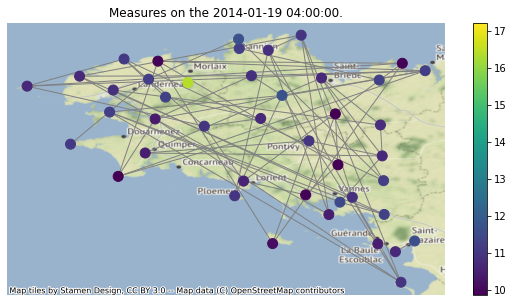

In [481]:
argmax_index = smoothness_df.argmax()
signal = temperature_df_no_nan.iloc[argmax_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_sgl.set_coordinates(stations_np)
G_sgl.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)